In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

In [15]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred - (x**2)*tf.cos(x) #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic = 0. #valor que queremos para la condicion inicial o el modelo en x_0
             loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

In [20]:
model = ODEsolver()

model.add(Dense(10, activation='tanh', input_shape=(1,)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(10, activation='tanh'))

model.add(Dense(1))


model.summary()

Model: "od_esolver_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                20        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 251 (1004.00 Byte)
Trainable params: 251 (1004.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


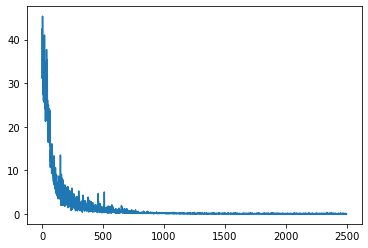

In [21]:
model.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=2500,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 1ms/step


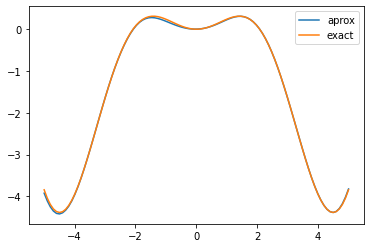

In [22]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv, (x**2-2)*np.sin(x)/x + 2*np.cos(x),label="exact")
plt.legend()
plt.show()

In [49]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32)
        max = tf.cast(tf.reduce_max(data),tf.float32)
        x = tf.random.uniform((batch_size,1), minval=min, maxval=max)
        with tf.GradientTape() as tape:

                    with tf.GradientTape(persistent=True) as gg:
                        gg.watch(x)

                        with tf.GradientTape(persistent=True) as ggg:
                            x_o = tf.zeros((batch_size,1))
                            ggg.watch(x)
                            ggg.watch(x_o)
                            y_pred = self(x, training=True)
                            y_o = self(x_o, training=True)
                        dy_dx = ggg.gradient(y_pred, x)
                        dy_dxo = ggg.gradient(y_o, x_o)

                    dy2_dx2 = gg.gradient(dy_dx, x)

                    eq = dy2_dx2 + y_pred
                    ic = y_o -1. 
                    ic2 = dy_dxo + 0.5
                    loss = keras.losses.mean_squared_error(0.,eq) + keras.losses.mean_squared_error(0., ic)+ keras.losses.mean_squared_error(0.,ic2)




                #aplica los gradientes        
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))


        #actualiza metricas
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
            
model = ODEsolver()
model.add(Dense(100, activation='tanh', input_shape=(1,)))
model.add(Dense(50, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))
model.summary()
model.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=2500,verbose=0)

Model: "od_esolver_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 100)               200       
                                                                 
 dense_56 (Dense)            (None, 50)                5050      
                                                                 
 dense_57 (Dense)            (None, 10)                510       
                                                                 
 dense_58 (Dense)            (None, 10)                110       
                                                                 
 dense_59 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5881 (22.97 KB)
Trainable params: 5881 (22.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


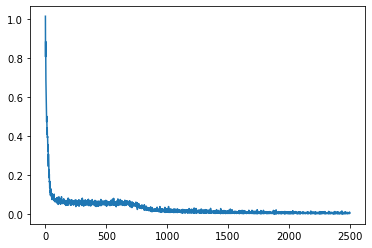

In [50]:
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 1ms/step


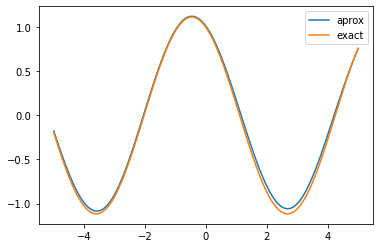

In [51]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv, np.cos(x)-0.5*np.sin(x),label="exact")
plt.legend()
plt.show()